#### The below script is an attempt to build a momentum overlay strategy for a long only book. 

The hypothesis here is that crypto exhibits extremely strong momentum characteristics (ie autocorrelation) vs other asset classes, which offers the potential for extreme outsized returns. Being able to exploit this during periodic market pumps has the potential to dramatically increase returns, but this needs to be done as part of a systematic, risk managed strategy.

Furthermore, I expect there are certain names/sectors (memes, AI coins, L1s) which are generally much more momentum driven than others (DeFi 1.0, dino L1s etc).

I propose a strategy based on EMA crossover which is designed to add 100% leverage when the 5 day EMA is more than 5% above the 20 day, with a broad uptrend filter of price 10% above the 50 day EMA. This is designed to reduce chop/ chasing false breakouts, which is extremely costly for momentum strategies.

Using the 5 day EMA rather than a 10 day allows us to exit the trade fairly quickly when the market turns, which is a good start as a risk management tool for limiting leveraged exposure at market tops.


In [1]:
import pandas as pd
import re
import requests
from datetime import datetime, timedelta, date
import numpy as np
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import matplotlib.dates as mdates
import time

import ccxt


#### First building our API functions

In [6]:
try:
    cryptocurrencies_list = 'complete_coins_list.csv'
except:
    data = fetch_cryptocurrencies()
    if data:
        save_to_csv_using_dataframe(data, 'complete_coins_list.csv')
    
cryptocurrencies_list = 'complete_coins_list.csv'
coins_list = pd.read_csv(cryptocurrencies_list)
coins_list = coins_list[coins_list['24h Volume'] > 500000]
crypto_symbols_set = set(coins_list['Ticker'].str.upper()) # faster lookup

In [2]:
def pull_prices_cg(days, coin):
    
    coin = coin.lower()

    filtered_series = coins_list[coins_list['Ticker'] == coin]['ID']

    # To get the index of the coin in the filtered series, wihc will be used in a loc lookuip
    indices = filtered_series.index

    if not indices.empty:
        first_index = indices[0]  # Gets the first index of the filtered series
        coin_id = coins_list.loc[first_index, 'ID']
    
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    parameters = {
        'vs_currency': 'usd',
        'days': days,
    }
    response = requests.get(url, params=parameters)
    data = response.json()

    df_prices = pd.DataFrame(data['prices'], columns=['time', 'price'])
    df_volumes = pd.DataFrame(data['total_volumes'], columns=['time', '24h_volume'])
    
    
    df_prices['Date'] = pd.to_datetime(df_prices['time'], unit='ms').dt.date  # Converts timestamp to date
    sorted_prices = df_prices.sort_values(by='time')
    daily_closing_prices = sorted_prices.drop_duplicates('Date', keep='last')[['Date', 'price']]
    daily_closing_prices.reset_index(inplace=True, drop=True)
    daily_closing_prices['Date'] = pd.to_datetime(daily_closing_prices['Date'])

    df_volumes['Date'] = pd.to_datetime(df_volumes['time'], unit='ms').dt.date  # Converts timestamp to date
    sorted_volumes = df_volumes.sort_values(by='time')
    daily_closing_volumes = sorted_volumes.drop_duplicates('Date', keep='last')[['Date', '24h_volume']]
    daily_closing_volumes.reset_index(inplace=True, drop=True)
    daily_closing_volumes['Date'] = pd.to_datetime(daily_closing_volumes['Date'])
    
    df_price = pd.merge(daily_closing_prices, daily_closing_volumes, on='Date')
    
    
    return df_price
    

In [3]:
def pull_prices(days, coin):
    exchange_id = 'binance'
    exchange_class = getattr(ccxt, exchange_id)
    exchange = exchange_class({
        'timeout': 30000,
        'enableRateLimit': True,
    })

    symbol = coin
    symbol = f'{coin}/USDT'
    timeframe = '1d'

    seven_days_ago = datetime.utcnow() - timedelta(days=days)
    since = int(seven_days_ago.timestamp() * 1000)  # Convert to milliseconds

    all_ohlcv = []
    limit = 500  # Adjust based on exchange limits

    # Fetch OHLCV data starting from x days ago, handling pagination if necessary
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        if len(ohlcv) == 0:
            break  # No more data to fetch
        all_ohlcv += ohlcv
        since = ohlcv[-1][0] + 1  # Update 'since' to get the next batch of data

    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df_prices = df[['timestamp', 'close', 'volume']]
    df_prices = df_prices.rename(columns={'timestamp': 'Date', 'close': 'price', 'volume':'24h_volume'})

    return df_prices

In [4]:
pull_prices(1150, 'SOL')

,Date,price,24h_volume
0,2021-01-29,3.8293,2992168.86
1,2021-01-30,4.2280,3944655.04
2,2021-01-31,4.2525,5438870.48
3,2021-02-01,4.6148,2097052.47
4,2021-02-02,5.2331,5278922.61
...,...,...,...
1145,2024-03-19,169.8200,16935298.87
1146,2024-03-20,191.7700,12365784.68
1147,2024-03-21,179.4600,8064316.56
1148,2024-03-22,175.2100,6152106.89


#### Now implementing this for BTC

In [45]:
days = 1150
coin = 'BTC'

       
df= pull_prices_cg(days, coin)

# Technicals
df['50d_ema'] = df['price'].ewm(span=50, adjust=False).mean()
df['20d_ema'] = df['price'].ewm(span=20, adjust=False).mean()
df['10d_ema'] = df['price'].ewm(span=10, adjust=False).mean()
df['5d_ema'] = df['price'].ewm(span=5, adjust=False).mean()  

df['10_20_ema'] = df['10d_ema'] / df['20d_ema'] 
df['5_20_ema'] = df['5d_ema'] / df['20d_ema'] 

df['10_20_acc'] = df['10_20_ema'] / df['10_20_ema'].rolling(window=5).mean()
df['5_20_acc'] = df['5_20_ema'] / df['5_20_ema'].rolling(window=5).mean()

# 14 day RSI
delta = df['price'].diff(1)
gain = (delta.where(delta > 0, 0)).ewm(alpha=1/14, adjust=False).mean()
loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/14, adjust=False).mean()
rs = gain / loss
df['14d_RSI'] = 100 - (100 / (1 + rs))


df['14d_rtn'] = (df['price'].shift(-14) - df['price'])/ df['price']
df['7d_rtn'] = (df['price'].shift(-7) - df['price'])/ df['price']

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date'], drop=True)

In [46]:
df['stance1'] = np.where(df['5_20_ema'] > 1.05, 1,0)
df['stance2'] = np.where(df['price'] > 1.1*(df['50d_ema']), 1,0)

df['stance1'] = df['stance1'].shift(1)
df['stance2'] = df['stance2'].shift(1)

df['stance'] = np.where(((df['stance1'] == 1) & (df['stance2'] == 1)),1,0)
df['stanceLO'] = np.where(((df['stance1'] == 1) & (df['stance2'] == 1)),2,1)

In [47]:
df

,Date,price,24h_volume,50d_ema,20d_ema,10d_ema,5d_ema,10_20_ema,5_20_ema,10_20_acc,5_20_acc,14d_RSI,14d_rtn,7d_rtn,stance1,stance2,stance,stanceLO
Date,,,,,,,,,,,,,,,,,,
2021-01-29,2021-01-29,33128.347529,5.107597e+10,33128.347529,33128.347529,33128.347529,33128.347529,1.000000,1.000000,NaN,NaN,NaN,0.443355,0.111329,NaN,NaN,0,1
2021-01-30,2021-01-30,34150.818767,9.746852e+10,33168.444440,33225.725742,33314.251390,33469.171275,1.002664,1.007327,NaN,NaN,100.000000,0.388376,0.112941,0.0,0.0,0,1
2021-01-31,2021-01-31,34199.519810,5.200125e+10,33208.878768,33318.468034,33475.209285,33712.620787,1.004704,1.011830,NaN,NaN,100.000000,0.372572,0.148537,0.0,0.0,0,1
2021-02-01,2021-02-01,33064.786767,4.248865e+10,33203.228101,33294.307913,33400.587009,33496.676113,1.003192,1.006078,NaN,NaN,44.957983,0.470080,0.174462,0.0,0.0,0,1
2021-02-02,2021-02-02,33405.990357,4.926886e+10,33211.179562,33304.944337,33401.569436,33466.447528,1.002901,1.004849,1.000208,0.998839,53.284444,0.433829,0.386206,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19,2024-03-19,67708.943609,5.110182e+10,58507.181969,65874.121372,68333.328405,68365.363513,1.037332,1.037818,0.988139,0.977115,58.581741,NaN,NaN,0.0,1.0,0,1
2024-03-20,2024-03-20,62132.517379,8.017942e+10,58649.351985,65517.778135,67205.908218,66287.748135,1.025766,1.011752,0.984273,0.967745,46.917088,NaN,NaN,0.0,1.0,0,1
2024-03-21,2024-03-21,67819.055707,7.083680e+10,59008.948209,65736.947427,67317.389580,66798.183992,1.024042,1.016144,0.989051,0.983850,56.441878,NaN,NaN,0.0,0.0,0,1


In [48]:
df['log_price'] = np.log(df['price'])
df['log_rtn'] = df['log_price'].diff()

df['equity_log_return'] = np.where(df['stance'] == 1, df['log_rtn'], 0)
df['cumulative_equity_return'] = df['equity_log_return'].cumsum().apply(np.exp)

df['equity_log_return_LO'] = np.where(df['stanceLO'] == 1, df['log_rtn'], np.where(df['stanceLO'] == 2, 2* df['log_rtn'], 0))
df['cumulative_equity_return_LO'] = df['equity_log_return_LO'].cumsum().apply(np.exp)

df['cumulative_price'] = df['log_rtn'].cumsum().apply(np.exp)

df

,Date,price,24h_volume,50d_ema,20d_ema,10d_ema,5d_ema,10_20_ema,5_20_ema,10_20_acc,...,stance2,stance,stanceLO,log_price,log_rtn,equity_log_return,cumulative_equity_return,equity_log_return_LO,cumulative_equity_return_LO,cumulative_price
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-29,2021-01-29,33128.347529,5.107597e+10,33128.347529,33128.347529,33128.347529,33128.347529,1.000000,1.000000,NaN,...,NaN,0,1,10.408145,NaN,0.0,1.000000,NaN,NaN,NaN
2021-01-30,2021-01-30,34150.818767,9.746852e+10,33168.444440,33225.725742,33314.251390,33469.171275,1.002664,1.007327,NaN,...,0.0,0,1,10.438542,0.030397,0.0,1.000000,0.030397,1.030864,1.030864
2021-01-31,2021-01-31,34199.519810,5.200125e+10,33208.878768,33318.468034,33475.209285,33712.620787,1.004704,1.011830,NaN,...,0.0,0,1,10.439967,0.001425,0.0,1.000000,0.001425,1.032334,1.032334
2021-02-01,2021-02-01,33064.786767,4.248865e+10,33203.228101,33294.307913,33400.587009,33496.676113,1.003192,1.006078,NaN,...,0.0,0,1,10.406224,-0.033743,0.0,1.000000,-0.033743,0.998081,0.998081
2021-02-02,2021-02-02,33405.990357,4.926886e+10,33211.179562,33304.944337,33401.569436,33466.447528,1.002901,1.004849,1.000208,...,0.0,0,1,10.416491,0.010266,0.0,1.000000,0.010266,1.008381,1.008381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19,2024-03-19,67708.943609,5.110182e+10,58507.181969,65874.121372,68333.328405,68365.363513,1.037332,1.037818,0.988139,...,1.0,0,1,11.122974,-0.010526,0.0,2.427802,-0.010526,4.962033,2.043837
2024-03-20,2024-03-20,62132.517379,8.017942e+10,58649.351985,65517.778135,67205.908218,66287.748135,1.025766,1.011752,0.984273,...,1.0,0,1,11.037025,-0.085949,0.0,2.427802,-0.085949,4.553366,1.875509
2024-03-21,2024-03-21,67819.055707,7.083680e+10,59008.948209,65736.947427,67317.389580,66798.183992,1.024042,1.016144,0.989051,...,0.0,0,1,11.124598,0.087574,0.0,2.427802,0.087574,4.970102,2.047161


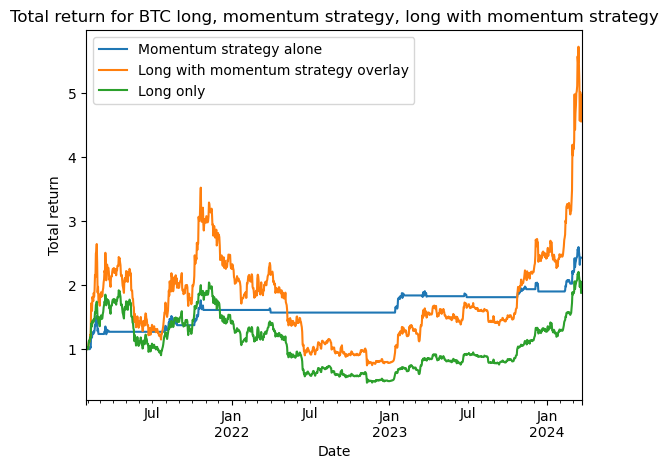

In [52]:
df['cumulative_equity_return'].plot(label ='Momentum strategy alone')
df['cumulative_equity_return_LO'].plot(label = 'Long with momentum strategy overlay')
df['cumulative_price'].plot(label = 'Long only')

plt.title('Total return for BTC long, momentum strategy, long with momentum strategy')
plt.ylabel('Total return')

plt.legend()

The results are encouraging. We can see that the overlay alone returned 140% over 3 years with 16 trades and very limited drawdowns due to the fast exit. 

As discussed, we are keen to limit trading activity and to avoid chop here and so 16 trades over 3 years is an acceptable number. Critically the strategy is fully deployed during the market rallies.

We have not factored in trading costs here for simplicity but as we are dealing with large cap coins and importantly fairly irregular trades it is likely that trading costs would have a limited impact on the strategy.

What is particularly interesting is the compound effect the overlay has on the long only position. The exposure to market rallies of 100% or more, with limited downside exposure and importantly the assumed reinvestment of gains with releveraging. Using this strategy even for BTC has the potential to dramatically improve returns in a risk controlled manner.

In [50]:
df['stance_diff'] = df['stance'].diff()
df['stance_diff'].value_counts()
df['trades'] = np.where(df['stance_diff'] == 1,1,0)
df['trades'].value_counts()

0    1134
1      16
Name: trades, dtype: int64

#### And for TAO, a momentum AI coin, which we would expect to work well with this overlay.

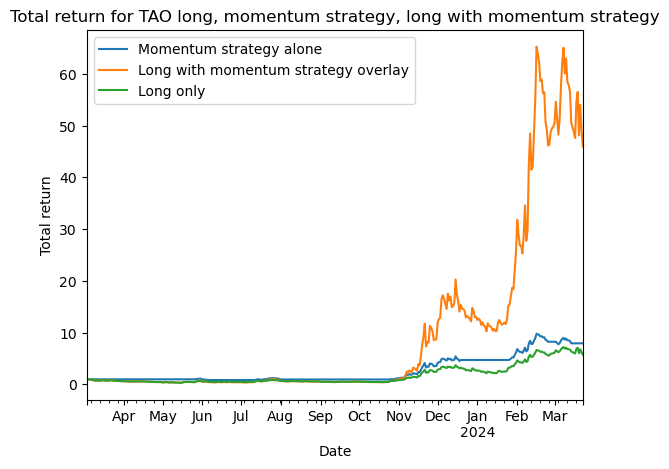

In [54]:
days = 1150
coin = 'TAO'

       
df= pull_prices_cg(days, coin)

# Technicals
df['50d_ema'] = df['price'].ewm(span=50, adjust=False).mean()
df['20d_ema'] = df['price'].ewm(span=20, adjust=False).mean()
df['10d_ema'] = df['price'].ewm(span=10, adjust=False).mean()
df['5d_ema'] = df['price'].ewm(span=5, adjust=False).mean()  

df['10_20_ema'] = df['10d_ema'] / df['20d_ema'] 
df['5_20_ema'] = df['5d_ema'] / df['20d_ema'] 

df['10_20_acc'] = df['10_20_ema'] / df['10_20_ema'].rolling(window=5).mean()
df['5_20_acc'] = df['5_20_ema'] / df['5_20_ema'].rolling(window=5).mean()

# 14 day RSI
delta = df['price'].diff(1)
gain = (delta.where(delta > 0, 0)).ewm(alpha=1/14, adjust=False).mean()
loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/14, adjust=False).mean()
rs = gain / loss
df['14d_RSI'] = 100 - (100 / (1 + rs))


df['14d_rtn'] = (df['price'].shift(-14) - df['price'])/ df['price']
df['7d_rtn'] = (df['price'].shift(-7) - df['price'])/ df['price']

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date'], drop=True)

df['stance1'] = np.where(df['5_20_ema'] > 1.05, 1,0)
df['stance2'] = np.where(df['price'] > 1.1*(df['50d_ema']), 1,0)

df['stance1'] = df['stance1'].shift(1)
df['stance2'] = df['stance2'].shift(1)

df['stance'] = np.where(((df['stance1'] == 1) & (df['stance2'] == 1)),1,0)
df['stanceLO'] = np.where(((df['stance1'] == 1) & (df['stance2'] == 1)),2,1)

df['log_price'] = np.log(df['price'])
df['log_rtn'] = df['log_price'].diff()

df['equity_log_return'] = np.where(df['stance'] == 1, df['log_rtn'], 0)
df['cumulative_equity_return'] = df['equity_log_return'].cumsum().apply(np.exp)

df['equity_log_return_LO'] = np.where(df['stanceLO'] == 1, df['log_rtn'], np.where(df['stanceLO'] == 2, 2* df['log_rtn'], 0))
df['cumulative_equity_return_LO'] = df['equity_log_return_LO'].cumsum().apply(np.exp)

df['cumulative_price'] = df['log_rtn'].cumsum().apply(np.exp)


df['cumulative_equity_return'].plot(label ='Momentum strategy alone')
df['cumulative_equity_return_LO'].plot(label = 'Long with momentum strategy overlay')
df['cumulative_price'].plot(label = 'Long only')

plt.title('Total return for TAO long, momentum strategy, long with momentum strategy')
plt.ylabel('Total return')

plt.legend()

In [44]:
df['stance_diff'] = df['stance'].diff()


In [42]:
df['stance_diff'].value_counts()
df['trades'] = np.where(df['stance_diff'] == 1,1,0)

In [43]:
df['trades'].value_counts()

0    381
1      6
Name: trades, dtype: int64

#### As expected the strategy is extremely successful and has only fired 6 times in the last year. 

In [33]:
df.to_csv('TAO.csv')

In [29]:
def overlay(days, coin):
    
    #df= pull_prices_cg(days, coin)
    df= pull_prices_cg(days, coin)


    # Technicals
    df['50d_ema'] = df['price'].ewm(span=50, adjust=False).mean()
    df['20d_ema'] = df['price'].ewm(span=20, adjust=False).mean()
    df['10d_ema'] = df['price'].ewm(span=10, adjust=False).mean()
    df['5d_ema'] = df['price'].ewm(span=5, adjust=False).mean()  

    df['10_20_ema'] = df['10d_ema'] / df['20d_ema'] 
    df['5_20_ema'] = df['5d_ema'] / df['20d_ema'] 

    df['10_20_acc'] = df['10_20_ema'] / df['10_20_ema'].rolling(window=5).mean()
    df['5_20_acc'] = df['5_20_ema'] / df['5_20_ema'].rolling(window=5).mean()

    # 14 day RSI
    delta = df['price'].diff(1)
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/14, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/14, adjust=False).mean()
    rs = gain / loss
    df['14d_RSI'] = 100 - (100 / (1 + rs))


    df['14d_rtn'] = (df['price'].shift(-14) - df['price'])/ df['price']
    df['7d_rtn'] = (df['price'].shift(-7) - df['price'])/ df['price']

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index(df['Date'], drop=True)
    
    df['stance1'] = np.where(df['5_20_ema'] > 1.05, 1,0)
    df['stance2'] = np.where(df['price'] > 1.1*(df['50d_ema']), 1,0)




    df['stance1'] = df['stance1'].shift(1)
    df['stance2'] = df['stance2'].shift(1)



    df['stance'] = np.where(((df['stance1'] == 1) & (df['stance2'] == 1)),1,0)
    df['stanceLO'] = np.where(((df['stance1'] == 1) & (df['stance2'] == 1)),2,1)


    df['log_price'] = np.log(df['price'])
    df['log_rtn'] = df['log_price'].diff()

    df['equity_log_return'] = np.where(df['stance'] == 1, df['log_rtn'], 0)
    df['cumulative_equity_return'] = df['equity_log_return'].cumsum().apply(np.exp)

    df['equity_log_return_LO'] = np.where(df['stanceLO'] == 1, df['log_rtn'], np.where(df['stanceLO'] == 2, 2* df['log_rtn'], 0))
    df['cumulative_equity_return_LO'] = df['equity_log_return_LO'].cumsum().apply(np.exp)

    df['cumulative_price'] = df['log_rtn'].cumsum().apply(np.exp)


    
    tr = df['cumulative_price'].iloc[-1]
    tr_strat = df['cumulative_equity_return'].iloc[-1]
    tr_LO = df['cumulative_equity_return_LO'].iloc[-1]
    
    
    ann_ret = df['cumulative_price'].iloc[-1]/ (len(df)/365)
    ann_std = df['log_rtn'].std()*np.sqrt(365)
    sharpe = ann_ret / ann_std 


    ann_ret_strat = df['cumulative_equity_return'].iloc[-1]/ (len(df)/365)
    ann_std_strat = df['equity_log_return'].std()*np.sqrt(365)
    sharpe_strat = ann_ret_strat / ann_std_strat

    ann_ret_LO = df['cumulative_equity_return_LO'].iloc[-1]/ (len(df)/365)
    ann_std_LO = df['equity_log_return_LO'].std()*np.sqrt(365)
    sharpe_LO = ann_ret_LO / ann_std_LO
    
    length = len(df)
    
    df['stance_diff'] = df['stance'].diff()
    df['trades'] = np.where(df['stance_diff'] == 1,1,0)
     

        
        
    #df['cumulative_equity_return'].plot()
    #df['cumulative_equity_return_LO'].plot()
    #df['cumulative_price'].plot()                     
    
    return length, tr, tr_strat, tr_LO, sharpe, sharpe_strat, sharpe_LO

In [15]:
overlay(1150, 'AVAX')

(1150,
 4.592150066897732,
 13.966300924851424,
 64.13534972637032,
 1.169694764980214,
 5.568563264035961,
 10.948263131038779)

#### Let's apply the strategy to 26 large cap coins across L1s, L2s, AI, Cosmos coins, memes and DeFi.

In the table, 

- TR is long only with no overlay, 
- TR_strat is the return of the overlay strategy alone
- TR_LO_strat is the return of the long only with added overlay
- I then have the respective Sharpe ratios and the number of days the strategy has been in effect

In [20]:
degen = ['BTC', 'ETH', 'MATIC', 'OP', 'ARB', 'SOL', 'AVAX', 'TON', 'DOT', 'PEPE', 'AKT', 'TAO', 'RNDR', 'TIA', 'ATOM', 'STRD', 'SHIB', 'WIF', 'BONK', 'DOGE', 'SNX', 'DYDX', 'AAVE', 'STX', 'LDO', 'RPL']

In [21]:
df_total = pd.DataFrame(columns = ['coin', 'TR', 'TR_strat', 'TR_LO_strat', 'Sharpe', 'Sharpe_strat', 'Sharpe_LO_strat', 'Days'])


In [22]:
for coin in degen[0:5]:
    print(coin)
    try:
        length, tr, tr_strat, tr_LO, sharpe, sharpe_strat, sharpe_LO = overlay(1200, coin)
        df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)
    except:
        None
    time.sleep(2)

df_total

BTC


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/2042083107.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


ETH


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/2042083107.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


MATIC


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/2042083107.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


OP


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/2042083107.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


ARB


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/2042083107.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


,coin,TR,TR_strat,TR_LO_strat,Sharpe,Sharpe_strat,Sharpe_LO_strat,Days
0,BTC,3.554172,3.908282,13.890707,1.667494,4.156833,5.177502,1200
1,ETH,6.045958,2.899040,17.527471,2.200758,1.985135,4.693422,1200
2,MATIC,56.197740,12.099025,679.937882,12.926278,3.778420,96.479605,1200
3,OP,2.833604,1.282872,3.635151,1.169781,0.861279,1.026842,662
4,ARB,1.224862,0.885494,1.084607,1.446233,2.104617,0.970091,367


In [23]:
for coin in degen[5:10]:
    print(coin)
    try:
        length, tr, tr_strat, tr_LO, sharpe, sharpe_strat, sharpe_LO = overlay(1200, coin)
        df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)
    except:
        None
    time.sleep(2)

df_total

SOL


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/2140713575.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


AVAX


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/2140713575.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


TON


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/2140713575.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


DOT


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/2140713575.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


PEPE


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/2140713575.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


,coin,TR,TR_strat,TR_LO_strat,Sharpe,Sharpe_strat,Sharpe_LO_strat,Days
0,BTC,3.554172,3.908282,13.890707,1.667494,4.156833,5.177502,1200
1,ETH,6.045958,2.899040,17.527471,2.200758,1.985135,4.693422,1200
2,MATIC,56.197740,12.099025,679.937882,12.926278,3.778420,96.479605,1200
3,OP,2.833604,1.282872,3.635151,1.169781,0.861279,1.026842,662
4,ARB,1.224862,0.885494,1.084607,1.446233,2.104617,0.970091,367
5,SOL,112.669770,190.446429,21457.555337,26.646481,67.999278,3333.058869,1200
6,AVAX,17.511667,51.139143,895.531643,4.172532,18.534646,140.729471,1200
7,TON,1.842588,1.517722,2.796537,20.113666,18.655619,16.532082,23
8,DOT,1.901756,4.279651,8.138853,0.538759,2.178885,1.659614,1200
9,PEPE,2.037534,5.463054,11.131155,1.388231,5.693395,5.011122,324


In [24]:
for coin in degen[10:15]:
    print(coin)
    try:
        length, tr, tr_strat, tr_LO, sharpe, sharpe_strat, sharpe_LO = overlay(1200, coin)
        df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)
    except:
        None
    time.sleep(2)

df_total

AKT
TAO
RNDR


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/3158963920.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


TIA


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/3158963920.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


ATOM


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/3158963920.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


,coin,TR,TR_strat,TR_LO_strat,Sharpe,Sharpe_strat,Sharpe_LO_strat,Days
0,BTC,3.554172,3.908282,13.890707,1.667494,4.156833,5.177502,1200
1,ETH,6.045958,2.899040,17.527471,2.200758,1.985135,4.693422,1200
2,MATIC,56.197740,12.099025,679.937882,12.926278,3.778420,96.479605,1200
3,OP,2.833604,1.282872,3.635151,1.169781,0.861279,1.026842,662
4,ARB,1.224862,0.885494,1.084607,1.446233,2.104617,0.970091,367
5,SOL,112.669770,190.446429,21457.555337,26.646481,67.999278,3333.058869,1200
6,AVAX,17.511667,51.139143,895.531643,4.172532,18.534646,140.729471,1200
7,TON,1.842588,1.517722,2.796537,20.113666,18.655619,16.532082,23
8,DOT,1.901756,4.279651,8.138853,0.538759,2.178885,1.659614,1200
9,PEPE,2.037534,5.463054,11.131155,1.388231,5.693395,5.011122,324


In [25]:
for coin in degen[15:20]:
    print(coin)
    try:
        length, tr, tr_strat, tr_LO, sharpe, sharpe_strat, sharpe_LO = overlay(1200, coin)
        df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)
    except:
        None
    time.sleep(2)

df_total

STRD
SHIB


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/1755650086.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


WIF


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/1755650086.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


BONK


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/1755650086.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


DOGE


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/1755650086.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


,coin,TR,TR_strat,TR_LO_strat,Sharpe,Sharpe_strat,Sharpe_LO_strat,Days
0,BTC,3.554172,3.908282,13.890707,1.667494,4.156833,5.177502,1200
1,ETH,6.045958,2.899040,17.527471,2.200758,1.985135,4.693422,1200
2,MATIC,56.197740,12.099025,679.937882,12.926278,3.778420,96.479605,1200
3,OP,2.833604,1.282872,3.635151,1.169781,0.861279,1.026842,662
4,ARB,1.224862,0.885494,1.084607,1.446233,2.104617,0.970091,367
5,SOL,112.669770,190.446429,21457.555337,26.646481,67.999278,3333.058869,1200
6,AVAX,17.511667,51.139143,895.531643,4.172532,18.534646,140.729471,1200
7,TON,1.842588,1.517722,2.796537,20.113666,18.655619,16.532082,23
8,DOT,1.901756,4.279651,8.138853,0.538759,2.178885,1.659614,1200
9,PEPE,2.037534,5.463054,11.131155,1.388231,5.693395,5.011122,324


In [26]:
for coin in degen[20:25]:
    print(coin)
    try:
        length, tr, tr_strat, tr_LO, sharpe, sharpe_strat, sharpe_LO = overlay(1200, coin)
        df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)
    except:
        None
    time.sleep(2)

df_total

SNX


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/1839143542.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


DYDX


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/1839143542.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


AAVE


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/1839143542.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


STX


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/1839143542.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


LDO


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/1839143542.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


,coin,TR,TR_strat,TR_LO_strat,Sharpe,Sharpe_strat,Sharpe_LO_strat,Days
0,BTC,3.554172,3.908282,13.890707,1.667494,4.156833,5.177502,1200
1,ETH,6.045958,2.899040,17.527471,2.200758,1.985135,4.693422,1200
2,MATIC,56.197740,12.099025,679.937882,12.926278,3.778420,96.479605,1200
3,OP,2.833604,1.282872,3.635151,1.169781,0.861279,1.026842,662
4,ARB,1.224862,0.885494,1.084607,1.446233,2.104617,0.970091,367
5,SOL,112.669770,190.446429,21457.555337,26.646481,67.999278,3333.058869,1200
6,AVAX,17.511667,51.139143,895.531643,4.172532,18.534646,140.729471,1200
7,TON,1.842588,1.517722,2.796537,20.113666,18.655619,16.532082,23
8,DOT,1.901756,4.279651,8.138853,0.538759,2.178885,1.659614,1200
9,PEPE,2.037534,5.463054,11.131155,1.388231,5.693395,5.011122,324


In [27]:
for coin in degen[25:30]:
    print(coin)
    try:
        length, tr, tr_strat, tr_LO, sharpe, sharpe_strat, sharpe_LO = overlay(1200, coin)
        df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)
    except:
        None
    time.sleep(2)

df_total

RPL


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/562094121.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


,coin,TR,TR_strat,TR_LO_strat,Sharpe,Sharpe_strat,Sharpe_LO_strat,Days
0,BTC,3.554172,3.908282,13.890707,1.667494,4.156833,5.177502,1200
1,ETH,6.045958,2.899040,17.527471,2.200758,1.985135,4.693422,1200
2,MATIC,56.197740,12.099025,679.937882,12.926278,3.778420,96.479605,1200
3,OP,2.833604,1.282872,3.635151,1.169781,0.861279,1.026842,662
4,ARB,1.224862,0.885494,1.084607,1.446233,2.104617,0.970091,367
5,SOL,112.669770,190.446429,21457.555337,26.646481,67.999278,3333.058869,1200
6,AVAX,17.511667,51.139143,895.531643,4.172532,18.534646,140.729471,1200
7,TON,1.842588,1.517722,2.796537,20.113666,18.655619,16.532082,23
8,DOT,1.901756,4.279651,8.138853,0.538759,2.178885,1.659614,1200
9,PEPE,2.037534,5.463054,11.131155,1.388231,5.693395,5.011122,324


In [56]:
#Using the coingecko API for those not on Binance

degen_cg = ['AKT', 'TAO', 'STRD']

for coin in degen_cg:
    print(coin)
    try:
        length, tr, tr_strat, tr_LO, sharpe, sharpe_strat, sharpe_LO = overlay(1200, coin)
        df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)
    except:
        None
    time.sleep(2)

df_total

AKT


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/1115134829.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


TAO


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/1115134829.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


STRD


/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_89747/1115134829.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append({'coin': coin, 'TR':tr, 'TR_strat': tr_strat, 'TR_LO_strat': tr_LO, 'Sharpe': sharpe, 'Sharpe_strat': sharpe_strat, 'Sharpe_LO_strat': sharpe_LO, 'Days': length}, ignore_index=True)


,coin,TR,TR_strat,TR_LO_strat,Sharpe,Sharpe_strat,Sharpe_LO_strat,Days
0,BTC,3.554172,3.908282,13.890707,1.667494,4.156833,5.177502,1200
1,ETH,6.045958,2.899040,17.527471,2.200758,1.985135,4.693422,1200
2,MATIC,56.197740,12.099025,679.937882,12.926278,3.778420,96.479605,1200
3,OP,2.833604,1.282872,3.635151,1.169781,0.861279,1.026842,662
4,ARB,1.224862,0.885494,1.084607,1.446233,2.104617,0.970091,367
5,SOL,112.669770,190.446429,21457.555337,26.646481,67.999278,3333.058869,1200
6,AVAX,17.511667,51.139143,895.531643,4.172532,18.534646,140.729471,1200
7,TON,1.842588,1.517722,2.796537,20.113666,18.655619,16.532082,23
8,DOT,1.901756,4.279651,8.138853,0.538759,2.178885,1.659614,1200
9,PEPE,2.037534,5.463054,11.131155,1.388231,5.693395,5.011122,324


#### In conclusion, we can see that there is a dramatic improvement in total returns and generally in Sharpe through adding the overlay for all but 3 of the names above (ARB, DYDX, RPL). Also the extreme convexity of the return distribution across the coins certainly makes up for a small number of losers.

I haven't yet optimised the parameters but these initial results are extremely encouraging. This strategy could easily be applied to a long only book in a low maintenance and risk controlled manner through perps and rebalanced on a daily basis.